In [1]:
"""
A simple example of the Stiefel landing algorithm on PCA problem
"""
from time import time

import sys
sys.path.append("../")

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import geoopt

from geoopt.optim import RiemannianSGD, RiemannianLineSearch
from landing_stiefel import LandingStiefelSGD
from models import VGG16
from utils import stiefel_project, stiefel_distance, get_conv2d

torch.manual_seed(0)

In [2]:
model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
model = VGG16()

Using cache found in /home/vary/.cache/torch/hub/pytorch_vision_v0.10.0


In [3]:
lambda_regul = 10
safe_step = None
learning_rate = 1e-4
weight_decay = 1e-4

In [4]:
conv2d_modules, ortho_params, other_params = get_conv2d(model, project=True)

optimizer = LandingStiefelSGD([
    {'params': ortho_params, 'lambda_regul': lambda_regul, 'safe_step' : safe_step},
    {'params': other_params}], lr=learning_rate, weight_decay = weight_decay)

In [5]:
stiefel_distance(ortho_params,device = 'cpu')

tensor(5.3602e-11, grad_fn=<AddBackward0>)

In [10]:
for param in optimizer.param_groups[0]['params']:
    param = stiefel_project(param.reshape(-1,9)).reshape(param.shape)
    

In [12]:
stiefel_distance(optimizer.param_groups[0]['params'],device = 'cpu')

tensor(19657.2676, grad_fn=<AddBackward0>)

In [18]:
param == parameter_list[0]

RuntimeError: The size of tensor a (64) must match the size of tensor b (3) at non-singleton dimension 3

In [15]:
ortho_params = []
other_params = []
for name, param in model.named_parameters():
    if len(param.shape) == 4:
        size_p = np.prod(param.shape[-2:])
        param = stiefel_project(param.reshape(-1,size_p)).reshape(param.shape)
        ortho_params.append(param)
    else:
        other_params.append(param)
optimizer = LandingStiefelSGD([
    {'params': ortho_params, 'lambda_regul': lambda_regul, 'safe_step' : safe_step},
    {'params': other_params}], lr=learning_rate, weight_decay = weight_decay)

In [16]:
optimizer.param_groups[0]['params'][0].device

device(type='cpu')

In [17]:
device = 'cpu'

In [18]:
stiefel_distance(ortho_params, device).item()

4.243341442111692e-11

In [133]:
out = ortho_params[0].reshape(-1,9).T @ ortho_params[0].reshape(-1,9)

In [135]:
out

tensor([[ 1.0000e+00,  2.1111e-07,  9.5944e-08,  3.3966e-08,  4.3902e-08,
          1.8772e-08,  1.0758e-08, -2.2451e-07,  3.5255e-08],
        [ 2.1111e-07,  1.0000e+00,  2.1260e-07, -2.5954e-07,  1.9242e-07,
         -2.0552e-07,  6.3738e-08, -1.5424e-07, -1.9436e-07],
        [ 9.5944e-08,  2.1260e-07,  1.0000e+00,  1.9927e-07, -1.8542e-07,
          3.3229e-08, -6.1591e-08, -1.7452e-08, -1.7403e-07],
        [ 3.3966e-08, -2.5954e-07,  1.9927e-07,  1.0000e+00,  7.2785e-09,
         -2.0661e-08,  3.3836e-08,  4.5400e-08,  6.5145e-08],
        [ 4.3902e-08,  1.9242e-07, -1.8542e-07,  7.2785e-09,  1.0000e+00,
          7.3716e-08,  1.1131e-07,  2.2505e-07, -6.3230e-08],
        [ 1.8772e-08, -2.0552e-07,  3.3229e-08, -2.0661e-08,  7.3716e-08,
          1.0000e+00,  1.9097e-07,  1.2982e-09, -7.4687e-09],
        [ 1.0758e-08,  6.3738e-08, -6.1591e-08,  3.3836e-08,  1.1131e-07,
          1.9097e-07,  1.0000e+00, -1.5951e-07,  2.8110e-07],
        [-2.2451e-07, -1.5424e-07, -1.7452e-08, 

In [117]:
ortho_params = []
other_params = []
for name, module in model.features.named_modules():
    print(module)
    print(module.parameters)
    if isinstance(module, torch.nn.Conv2d):
        ortho_params.append(module.weight)
        other_params.append(module.bias)
    else:
        other_params.append(module.parameters())

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [114]:
other_params

[<generator object Module.parameters at 0x7feafc1cac80>,
 Parameter containing:
 tensor([ 0.0593, -0.1544,  0.0302,  0.1582,  0.1295,  0.1645,  0.1040, -0.0159,
          0.0502, -0.0803,  0.1630,  0.0962, -0.1406,  0.1661, -0.0029, -0.0085,
         -0.0526, -0.0507,  0.0096, -0.0938, -0.1787, -0.0989, -0.0382,  0.1450,
          0.1413, -0.1151, -0.0074, -0.0554, -0.1028, -0.0338, -0.0666,  0.1074,
         -0.0953,  0.0296, -0.1084, -0.0599,  0.1512, -0.0943, -0.0115,  0.1834,
          0.0657, -0.0978, -0.1153, -0.0674, -0.0601,  0.0836, -0.0427,  0.1620,
         -0.1054, -0.0601,  0.0699,  0.1534,  0.1837,  0.0307,  0.0081, -0.0861,
          0.1085, -0.1113, -0.0505, -0.1605, -0.1846,  0.1074,  0.0130,  0.1531],
        requires_grad=True),
 <generator object Module.parameters at 0x7feafc266900>,
 <generator object Module.parameters at 0x7feafc181740>,
 Parameter containing:
 tensor([-0.0015,  0.0272, -0.0400, -0.0131,  0.0215, -0.0094,  0.0269,  0.0143,
          0.0072, -0.005

In [118]:
optimizer = LandingStiefelSGD([
    {'params': ortho_params, 'lambda_regul': lambda_regul, 'safe_step' : safe_step},
    {'params': other_params}], lr=learning_rate, weight_decay = weight_decay)

TypeError: optimizer can only optimize Tensors, but one of the params is Module.parameters

In [90]:
i = 0
for name, module in model.features.named_modules():
    i = i + 1
    print(module)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [89]:
print(i)

48


In [58]:
aother_params

[<bound method Module.named_parameters of VGG16(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (9): ReLU(inplace=True)
     (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (12): ReLU(inplace=True)
     (13): MaxPool2d(kernel_size=2, stride=2, paddin

In [68]:
optimizer = LandingStiefelSGD([
    {'params': ortho_params, 'lambda_regul': lambda_regul, 'safe_step' : safe_step},
    {'params': other_params}], lr=learning_rate, weight_decay = weight_decay)

TypeError: optimizer can only optimize Tensors, but one of the params is Module.named_parameters

In [44]:
checkpoint = torch.load('../2_cifar10_landing.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['train_loss_values']

[0.24519581319121145]

In [162]:
x = torch.randn(1,5,5, requires_grad=True)

In [172]:
a(x).sum().backward()
print(x.grad)
print(a.weight.grad)
x.grad.zero_()
a.weight.grad.zero_()

tensor([[[0.4388, 0.4762, 0.7072, 1.0316, 0.8435],
         [0.6971, 0.5663, 0.9288, 0.8537, 0.8207],
         [0.5316, 0.4748, 0.4631, 0.7435, 0.4784],
         [0.4221, 0.2032, 0.1765, 0.4066, 0.1703],
         [0.4551, 0.2831, 0.1114, 0.4090, 0.2633]]])
tensor([[[[4.2471, 1.4839, 3.9566, 3.1016, 2.0414],
          [3.1303, 0.4339, 2.5813, 0.4123, 0.8655],
          [5.7128, 3.3247, 5.4217, 2.2058, 2.6583],
          [3.1457, 1.8538, 2.7748, 0.5103, 1.0967],
          [3.0648, 2.5750, 3.5712, 0.5901, 1.0401]]],


        [[[4.2471, 1.4839, 3.9566, 3.1016, 2.0414],
          [3.1303, 0.4339, 2.5813, 0.4123, 0.8655],
          [5.7128, 3.3247, 5.4217, 2.2058, 2.6583],
          [3.1457, 1.8538, 2.7748, 0.5103, 1.0967],
          [3.0648, 2.5750, 3.5712, 0.5901, 1.0401]]],


        [[[4.2471, 1.4839, 3.9566, 3.1016, 2.0414],
          [3.1303, 0.4339, 2.5813, 0.4123, 0.8655],
          [5.7128, 3.3247, 5.4217, 2.2058, 2.6583],
          [3.1457, 1.8538, 2.7748, 0.5103, 1.0967],
       

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

In [173]:
b(x).sum().backward()
print(x.grad)
print(b.weight.grad)
x.grad.zero_()
b.weight.grad.zero_()

tensor([[[ 4.3880,  4.7619,  7.0716, 10.3162,  8.4348],
         [ 6.9705,  5.6632,  9.2877,  8.5366,  8.2066],
         [ 5.3160,  4.7481,  4.6308,  7.4347,  4.7839],
         [ 4.2211,  2.0323,  1.7651,  4.0656,  1.7026],
         [ 4.5509,  2.8312,  1.1139,  4.0898,  2.6328]]])
tensor([[[[4.2471, 1.4839, 3.9566, 3.1016, 2.0414],
          [3.1303, 0.4339, 2.5813, 0.4123, 0.8655],
          [5.7128, 3.3247, 5.4217, 2.2058, 2.6583],
          [3.1457, 1.8538, 2.7748, 0.5103, 1.0967],
          [3.0648, 2.5750, 3.5712, 0.5901, 1.0401]]],


        [[[4.2471, 1.4839, 3.9566, 3.1016, 2.0414],
          [3.1303, 0.4339, 2.5813, 0.4123, 0.8655],
          [5.7128, 3.3247, 5.4217, 2.2058, 2.6583],
          [3.1457, 1.8538, 2.7748, 0.5103, 1.0967],
          [3.0648, 2.5750, 3.5712, 0.5901, 1.0401]]],


        [[[4.2471, 1.4839, 3.9566, 3.1016, 2.0414],
          [3.1303, 0.4339, 2.5813, 0.4123, 0.8655],
          [5.7128, 3.3247, 5.4217, 2.2058, 2.6583],
          [3.1457, 1.8538, 2.7748,

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

In [168]:
b.weight.grad

tensor([[[[12.7414,  4.4516, 11.8697,  9.3048,  6.1242],
          [ 9.3909,  1.3018,  7.7439,  1.2369,  2.5964],
          [17.1383,  9.9742, 16.2650,  6.6175,  7.9749],
          [ 9.4371,  5.5613,  8.3243,  1.5308,  3.2901],
          [ 9.1945,  7.7250, 10.7136,  1.7703,  3.1204]]],


        [[[12.7414,  4.4516, 11.8697,  9.3048,  6.1242],
          [ 9.3909,  1.3018,  7.7439,  1.2369,  2.5964],
          [17.1383,  9.9742, 16.2650,  6.6175,  7.9749],
          [ 9.4371,  5.5613,  8.3243,  1.5308,  3.2901],
          [ 9.1945,  7.7250, 10.7136,  1.7703,  3.1204]]],


        [[[12.7414,  4.4516, 11.8697,  9.3048,  6.1242],
          [ 9.3909,  1.3018,  7.7439,  1.2369,  2.5964],
          [17.1383,  9.9742, 16.2650,  6.6175,  7.9749],
          [ 9.4371,  5.5613,  8.3243,  1.5308,  3.2901],
          [ 9.1945,  7.7250, 10.7136,  1.7703,  3.1204]]],


        [[[12.7414,  4.4516, 11.8697,  9.3048,  6.1242],
          [ 9.3909,  1.3018,  7.7439,  1.2369,  2.5964],
          [17.1383,

In [169]:
a.weight.grad

tensor([[[[ 8.4943,  2.9678,  7.9131,  6.2032,  4.0828],
          [ 6.2606,  0.8679,  5.1626,  0.8246,  1.7309],
          [11.4255,  6.6495, 10.8433,  4.4116,  5.3166],
          [ 6.2914,  3.7075,  5.5495,  1.0205,  2.1934],
          [ 6.1297,  5.1500,  7.1424,  1.1802,  2.0803]]],


        [[[ 8.4943,  2.9678,  7.9131,  6.2032,  4.0828],
          [ 6.2606,  0.8679,  5.1626,  0.8246,  1.7309],
          [11.4255,  6.6495, 10.8433,  4.4116,  5.3166],
          [ 6.2914,  3.7075,  5.5495,  1.0205,  2.1934],
          [ 6.1297,  5.1500,  7.1424,  1.1802,  2.0803]]],


        [[[ 8.4943,  2.9678,  7.9131,  6.2032,  4.0828],
          [ 6.2606,  0.8679,  5.1626,  0.8246,  1.7309],
          [11.4255,  6.6495, 10.8433,  4.4116,  5.3166],
          [ 6.2914,  3.7075,  5.5495,  1.0205,  2.1934],
          [ 6.1297,  5.1500,  7.1424,  1.1802,  2.0803]]],


        [[[ 8.4943,  2.9678,  7.9131,  6.2032,  4.0828],
          [ 6.2606,  0.8679,  5.1626,  0.8246,  1.7309],
          [11.4255,

In [96]:
a.weight.grad

tensor([[[[-0.4033,  1.5427,  1.5105,  2.2178,  1.9829],
          [ 0.2524,  0.7941, -0.9864, -1.1109, -0.5428],
          [ 1.2148,  1.1069, -0.7120, -2.2599, -1.3896],
          [ 3.4980,  2.5922,  0.1930, -2.0589, -0.8239],
          [ 1.3437, -0.7099, -0.4056, -3.6416, -1.8663]]],


        [[[-0.4033,  1.5427,  1.5105,  2.2178,  1.9829],
          [ 0.2524,  0.7941, -0.9864, -1.1109, -0.5428],
          [ 1.2148,  1.1069, -0.7120, -2.2599, -1.3896],
          [ 3.4980,  2.5922,  0.1930, -2.0589, -0.8239],
          [ 1.3437, -0.7099, -0.4056, -3.6416, -1.8663]]],


        [[[-0.4033,  1.5427,  1.5105,  2.2178,  1.9829],
          [ 0.2524,  0.7941, -0.9864, -1.1109, -0.5428],
          [ 1.2148,  1.1069, -0.7120, -2.2599, -1.3896],
          [ 3.4980,  2.5922,  0.1930, -2.0589, -0.8239],
          [ 1.3437, -0.7099, -0.4056, -3.6416, -1.8663]]],


        [[[-0.4033,  1.5427,  1.5105,  2.2178,  1.9829],
          [ 0.2524,  0.7941, -0.9864, -1.1109, -0.5428],
          [ 1.2148,

In [94]:
print(x.grad)

None


In [99]:
a.zero_grad()
b(x).sum().backward()

(None,)


In [101]:
a.weight.grad 

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

In [102]:
b.weight.grad

tensor([[[[-0.4033,  1.5427,  1.5105,  2.2178,  1.9829],
          [ 0.2524,  0.7941, -0.9864, -1.1109, -0.5428],
          [ 1.2148,  1.1069, -0.7120, -2.2599, -1.3896],
          [ 3.4980,  2.5922,  0.1930, -2.0589, -0.8239],
          [ 1.3437, -0.7099, -0.4056, -3.6416, -1.8663]]],


        [[[-0.4033,  1.5427,  1.5105,  2.2178,  1.9829],
          [ 0.2524,  0.7941, -0.9864, -1.1109, -0.5428],
          [ 1.2148,  1.1069, -0.7120, -2.2599, -1.3896],
          [ 3.4980,  2.5922,  0.1930, -2.0589, -0.8239],
          [ 1.3437, -0.7099, -0.4056, -3.6416, -1.8663]]],


        [[[-0.4033,  1.5427,  1.5105,  2.2178,  1.9829],
          [ 0.2524,  0.7941, -0.9864, -1.1109, -0.5428],
          [ 1.2148,  1.1069, -0.7120, -2.2599, -1.3896],
          [ 3.4980,  2.5922,  0.1930, -2.0589, -0.8239],
          [ 1.3437, -0.7099, -0.4056, -3.6416, -1.8663]]],


        [[[-0.4033,  1.5427,  1.5105,  2.2178,  1.9829],
          [ 0.2524,  0.7941, -0.9864, -1.1109, -0.5428],
          [ 1.2148,

In [100]:
a.weight.grad == b.weight.grad

tensor([[[[False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False]]],


        [[[False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False]]],


        [[[False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False]]],


        [[[False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False]]],


        [[[False, False, False, False, False

In [67]:
b.weight.grad

In [3]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        self.loss_func = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        '''
        One forward pass through the network.
        
        Args:
            x: input
        '''
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)
    
    def loss(self, logits, y):
        return self.loss_func(logits, y)

    def correct(self, logits, y):
        return torch.eq(torch.argmax(logits, dim=1), y).float().sum()

In [4]:
model = LeNet()
device = torch.device('cuda')
model = model.to(device)


In [5]:
orth_param = []
other_params = []
for name, child in model.named_children():
    if isinstance(child, nn.modules.conv.Conv2d):
        #print(name, child)
        for name, param in child.named_parameters():
            if name == 'weight':
                orth_param.append(param)
            else:
                other_params.append(param)
    else:
        for name, param in child.named_parameters():
            other_params.append(param)


In [6]:
learning_rate = 1e-2
optimizer = LandingStiefelSGD([
                {'params': other_params, 'params_type': None},
                {'params': orth_param, 'lambda_regul': 10, 'safe_step' : .5, 'params_type': 'stiefel_conv2d'}], lr=learning_rate)

In [2]:
class OrthoConv2D(nn.Conv2d):
    def __init__(self, lambda_regul):
        super(OrthoConv2D, self).__init__()
        self.register_backward_hook(lambda grad: grad * 2)
    

NameError: name 'nn' is not defined

In [7]:
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)

In [8]:
model.train()
best_test_acc = 0.
epochs = 20
for epoch in range(epochs):
    processed = 0
    for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        logits = model(batch_x)
        loss = model.loss(logits, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_loss = 0.
        correct = 0.
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            test_loss += model.loss(logits, batch_y).float()
            correct += model.correct(logits, batch_y).float()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / len(test_loader.dataset)
    best_test_acc = max(test_acc, best_test_acc)
    print("Test set: Average loss: {:.4f}, Accuracy: {:.2f}%, Best Accuracy: {:.2f}%".format(test_loss, test_acc, best_test_acc))

    model.train()


tensor(-0.0122, device='cuda:0')
tensor(-0.0122, device='cuda:0')
tensor(-0.0149, device='cuda:0')
tensor(-0.0149, device='cuda:0')
tensor(-0.0120, device='cuda:0')
tensor(-0.0120, device='cuda:0')
tensor(-0.0140, device='cuda:0')
tensor(-0.0140, device='cuda:0')
tensor(-0.0119, device='cuda:0')
tensor(-0.0119, device='cuda:0')
tensor(-0.0133, device='cuda:0')
tensor(-0.0133, device='cuda:0')
tensor(-0.0118, device='cuda:0')
tensor(-0.0118, device='cuda:0')
tensor(-0.0128, device='cuda:0')
tensor(-0.0128, device='cuda:0')
tensor(-0.0117, device='cuda:0')
tensor(-0.0117, device='cuda:0')
tensor(-0.0125, device='cuda:0')
tensor(-0.0125, device='cuda:0')
tensor(-0.0116, device='cuda:0')
tensor(-0.0116, device='cuda:0')
tensor(-0.0122, device='cuda:0')
tensor(-0.0122, device='cuda:0')
tensor(-0.0116, device='cuda:0')
tensor(-0.0116, device='cuda:0')
tensor(-0.0120, device='cuda:0')
tensor(-0.0120, device='cuda:0')
tensor(-0.0115, device='cuda:0')
tensor(-0.0115, device='cuda:0')
tensor(-0.

KeyboardInterrupt: 

In [69]:
h = model.conv2.weight.view(-1,25).T @ model.conv2.weight.view(-1,25)

In [70]:
h = h.detach().cpu().numpy()

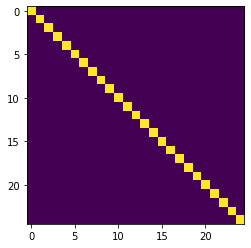

In [71]:
plt.imshow(h)

In [60]:
model.conv2.weight.view(-1,25).T @ model.conv2.weight.view(-1,25)

tensor([[1.0000e+00, 2.0433e-06, 1.8794e-06, 1.7732e-06, 1.2144e-06, 1.5739e-06,
         1.9222e-06, 1.3374e-06, 1.4305e-06, 1.2964e-06, 1.7397e-06, 1.7919e-06,
         1.5050e-06, 1.4305e-06, 1.3597e-06, 1.3188e-06, 1.6876e-06, 1.1995e-06,
         1.3262e-06, 1.1772e-06, 1.4603e-06, 1.7211e-06, 1.4417e-06, 1.1399e-06,
         1.3709e-06],
        [2.0433e-06, 1.0000e+00, 2.9467e-06, 2.2445e-06, 1.5981e-06, 1.7527e-06,
         2.5928e-06, 1.3374e-06, 1.6429e-06, 1.9008e-06, 2.0340e-06, 2.4699e-06,
         1.8775e-06, 1.5832e-06, 1.9446e-06, 1.4529e-06, 2.0675e-06, 1.5423e-06,
         1.6764e-06, 1.8366e-06, 1.7164e-06, 2.4512e-06, 2.1178e-06, 1.5385e-06,
         2.2203e-06],
        [1.8794e-06, 2.9467e-06, 1.0000e+00, 2.4624e-06, 2.1178e-06, 1.5981e-06,
         2.9039e-06, 1.4305e-06, 1.5423e-06, 2.1867e-06, 2.0992e-06, 3.0696e-06,
         2.1309e-06, 1.5963e-06, 2.2147e-06, 1.4640e-06, 2.2873e-06, 1.9893e-06,
         2.0787e-06, 2.1309e-06, 1.5013e-06, 2.5546e-06, 2.6766e-

In [87]:
logits = model(batch_x)


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [84]:
loss = model.loss(logits, batch_y)

AttributeError: 'LeNet' object has no attribute 'loss'